# Capstone Project
# Relocation Support
### Sidclay da Silva
### June 2020
---

### Introduction

This notebook contains the Capstone Project as the Week 5 peer-graded assignment for the Course IBM Applied Data Science Capstone on Coursera, which requires to develop a solution for the problem proposed by the learner in his Project Proposal Week 4, the stablished condition requires to make use of __API Foursquare__ to solve the proposed problem.

The proposed problem for this project is to support people to relocate giving them directions by creating a districts, or neighborhoods, rank for the target location using the relocator profile.

---

### Step 1 - Define the _Relocator Profile_ and _Target Location_

For this project the __Relocator Profile__ will be arbitrary defined to simulate a family relocating to also arbitrary defined __Target Location São Paulo, Brazil__.

__Family components__;
* 2 adults
* 2 kids in primary school age
* 1 dog as pet

__Family priorities__;
* __Primary school__ for the kids
* __Outdoor park__ to go with the kids, walk with the dog and jogging
* __Supermarket__ for the daily life
* __Pharmacy__ in case of emergencies, specially having kids
* __Subway or metro station__ to avoid traffic

__Housing wishes__;
* Apartment
* 2 or 3 bedrooms
* 80 m<sup>2</sup> approximately
* 1 garage spot

__Rental budget__;
* BRL 2,000.00 / month

Based on the Relocator Profile, define objects to be used to rank the districts of the target location.

Family priorities will be translated into a _dictionary_ containing venues categories according to the __API Foursquare__, the _dictionary keys_ will be __CategoryId__ from __API Foursquare__ and _dictionary values_ the categories names. Housing wishes and Rental budget will be converted in a _variable_ containg the rental budget per square meter - BRL/m<sup>2</sup>. Enabling some flexibility and opening more options to the Relocator, a tolerance for rental prices will be set to +-5%.

In [1]:
# create priorities list according to API Foursquare categories {'CategoryId': 'Category Name'}
prio_list = {'4f4533804b9074f6e4fb0105': 'Elementary School',
             '4bf58dd8d48988d163941735': 'Park',
             '52f2ab2ebcbc57f1066b8b46': 'Supermarket',
             '4bf58dd8d48988d10f951735': 'Pharmacy',
             '4bf58dd8d48988d1fd931735': 'Metro Station'}

# calculate rental budget per square meter based in target area and budget
target_area = 80
target_budget = 2000
tolera_budget = 0.05

budget_sqm = target_budget / target_area
budget_sqm_min = budget_sqm * (1 - tolera_budget)
budget_sqm_max = budget_sqm * (1 + tolera_budget)

# print objects
print('Family priorities are:', list(prio_list.values()), '\n')
print('Monthly rental budget is BRL {:,.2f} for a {} sqm apartment = BRL {:,.2f}/sqm/month\n'.\
      format(target_budget, target_area, budget_sqm))
print('Rental prices will be considered ranging from {:,.2f}/sqm/month up to {:,.2f}/sqm/month'.\
      format(budget_sqm_min, budget_sqm_max))

Family priorities are: ['Elementary School', 'Park', 'Supermarket', 'Pharmacy', 'Metro Station'] 

Monthly rental budget is BRL 2,000.00 for a 80 sqm apartment = BRL 25.00/sqm/month

Rental prices will be considered ranging from 23.75/sqm/month up to 26.25/sqm/month


---

### Step 2 - Acquire Districts Data of _Target Location_

The city of São Paulo is divided in 5 geographical regions, 32 boroughs, 96 districts and hundreds of neighborhoods. The city division up to the district level can be found in the official city web site, its is stored in a XLSX table format into a HTML page. The project will be based on district level to create the rank.
The current table is from 2017 and can be viewed at the following link;

[Prefeitura de São Paulo (SP) Regiões, Prefeituras Regionas e Distritos](http://www.prefeitura.sp.gov.br/cidade/secretarias/upload/urbanismo/infocidade/htmls/3_regioes_prefeituras_regionais_e_distrito_2017_10895.html)

To create a dataframe for the Districts of São Paulo, a request to the above URL will be done, its content parsed, cleaned and organized, to be stored in so called __Districts Dataframe__.

First thing, import required libraries;

1. __Pandas__: manipulate dataframe objects
1. __Numpy__: manipulate arrays and matrices calculations
1. __Requests__: send and receive url requests
1. __BeautifulSoup__: parse url content

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs

Send request to the above URL using _requests.get_ method.

In [3]:
# define a variable for the url
url = 'http://www.prefeitura.sp.gov.br/cidade/secretarias/upload/urbanismo/infocidade/htmls/3_regioes_prefeituras_regionais_e_distrito_2017_10895.html'

# send a request to the URL and store the response
raw = requests.get(url)

# check if data was loaded [status 200 means success]
if raw:
    print('Data loaded, status', raw.status_code)
else:
    print('Error loading data', raw.status_code)

Data loaded, status 200


Parse the URL content using _BeautifulSoup_ with _HTML_ parser.

In [4]:
# parse the raw data
par = bs(raw.text, 'html.parser')
print('URL content parsed.')

URL content parsed.


Check the returned content. Initially, how many tables it contains, the HTML tag _table_ will be the reference for counting.

In [5]:
# print number of tables
print('{} table(s) found in the parsed URL.'.format(len(par.find_all('table'))))

1 table(s) found in the parsed URL.


As it is a table in _XLSX_ format, all its content is stored in one unique table, including table description, headers, data, summary and footnotes. The data should be extract from this unique table, but, first get the table out of the parsed content, HTML tag _table_ will be the reference as well.

In [6]:
# get the table out of the parsed content
par_table = par.find_all('table')[0]

Check if there is any table header and how many rows the table contains. HTML tags _th_ and _tr_ will be respectively used for counting.

In [7]:
# print the number of headers and rows
print('{} header(s) and {} row(s) found in the table.'.format(len(par_table.find_all('th')),
                                                              len(par_table.find_all('tr'))))

0 header(s) and 110 row(s) found in the table.


From the 110 rows, 96 of them should be the required districts data, the remaining rows should be titles, summaries and footnotes rows.

Extract the data from the table to a list and check where the required data is located. This will be done running a nested loop through the rows, on the first level, and columns, on the second level. HTML tag _tr_ will be used to extract rows and _td_ to extract the columns.

In [8]:
# create an empty list for the entire table
tabletmp = []

# run a loop by row [tag 'tr']
for i, row in enumerate(par_table.find_all('tr')):
    # create an empty list for the current row
    celltmp = []

    # run a loop by column for the current row [tag 'td']
    for j, column in enumerate(row.find_all('td')):
        # append the text of current cell to the list
        celltmp.append(column.get_text())

    # append current line to the list
    tabletmp.append(celltmp)
        
# inform the number of rows loaded
print('{} rows loaded.'.format(len(tabletmp)))

110 rows loaded.


All the 110 rows have been loaded. Check the head and tail of the list to define the range of required data.

In [9]:
# print the first 10 rows
print('Head 10 rows')
tabletmp[:10]

Head 10 rows


[['Regiões, Prefeituras Regionais e Distritos Municipais',
  '\xa0',
  '',
  '',
  '',
  '',
  ''],
 ['Município de São Paulo', '\xa0', '', '', '', ''],
 ['2017', '\xa0', '\xa0', '', '', '', ''],
 ['', '', '', '', ''],
 ['Regiões',
  'Prefeituras\r\n  Regionais',
  'Distritos',
  'Área (ha)',
  'Área (km²)',
  '',
  '',
  ''],
 ['Centro', 'Sé', 'Bela Vista', '271,77', '2,72', '', '', ''],
 ['Bom Retiro', '420,54', '4,21', '', '', ''],
 ['Cambuci', '392,42', '3,92', '', '', ''],
 ['Consolação', '381,51', '3,82', '', '', ''],
 ['Liberdade', '365,07', '3,65', '', '', '']]

The first 4 rows are the table titles and can be ignored, row 5 contains the columns headers.

Check the tail of the table.

In [10]:
#print the last 10 rows
print('Tail 10 rows')
tabletmp[-10:]

Tail 10 rows


[['Vila Mariana', '859,56', '8,60', '', '', '', ''],
 ['Município de São\r\n  Paulo', '', '152.753,58', '1.527,54', '', '', '', ''],
 ['', '', '', '', '', '', '', ''],
 ['Fonte:\r\n  Prefeitura do Município de São Paulo. /\xa0\r\n  Instituto\xa0 Geográfico e\r\n  Cartográfico\xa0 do Estado de São Paulo.',
  '\xa0',
  '',
  '',
  '\xa0'],
 ['Elaboração:\r\n  SMUL/Deinfo', '\xa0', '\xa0', '', '', '\xa0'],
 ['Nota: Distritos Lei\r\n  nº 11.220/1992', '', '', ''],
 ['Subprefeituras\r\n  Lei nº 13.399/2002, alterada pelas Leis nº 13.682/2003 e nº 15.764/2013',
  '',
  '',
  ''],
 ['Base\r\n  de cálculo das áreas: Mapa Digital da Cidade (MDC) - UTM/SAD69-96.',
  '',
  '',
  ''],
 ['', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', '', '']]

The last 8 rows are the columns summary and footnotes, will also be ignored.

Check the columns headers, row 5 (index 4).

In [11]:
# check the columns headers
tabletmp[4]

['Regiões',
 'Prefeituras\r\n  Regionais',
 'Distritos',
 'Área (ha)',
 'Área (km²)',
 '',
 '',
 '']

There are 8 columns, but the last 3 are empty, the first 5 are the following:

* __Region__ (Regiões), the first column is the city Region to which the District belongs
* __Borough__ (Prefeituras Regionais), the second column is the Borough location
* __District__ (Distritos), the third column is the District name
* Area ha (Área (ha)), the fourth column is the neighborhood land area in hectares, it is not relevant for this project and it will be ignored
* __Area km<sup>2</sup>__ (Área (km<sup>2</sup>)), the fifth column is the neighborhood land area in square kilometers

Define the columns names for the __Districts Dataframe__.

In [12]:
# define the columns names
column_names = ['region', 'borough', 'district', 'area_sqkm']

At the top are 4 title rows and 1 header row, the first 5 rows at the top will be ignored. At the bottom 8 rows will be ignored, 1 summary and 7 footnotes rows. District data ranges from row 6 (index 5) to row 101 (index 100), counting 96 districts in São Paulo.

Extract only the data rows from the table and count the number of rows left.

In [13]:
# extract only required rows
tabletmp = tabletmp[5:101]

# print number rows left
print('{} rows left.'.format(len(tabletmp)))

96 rows left.


Before extracting the data, check the head and tail to see how the data is stored.

In [14]:
# print the first 10 rows
print('Head 10 rows')
tabletmp[:10]

Head 10 rows


[['Centro', 'Sé', 'Bela Vista', '271,77', '2,72', '', '', ''],
 ['Bom Retiro', '420,54', '4,21', '', '', ''],
 ['Cambuci', '392,42', '3,92', '', '', ''],
 ['Consolação', '381,51', '3,82', '', '', ''],
 ['Liberdade', '365,07', '3,65', '', '', ''],
 ['República', '239,67', '2,40', '', '', ''],
 ['Santa Cecília', '375,92', '3,76', '', '', ''],
 ['Sé', '219,36', '2,19', '', '', ''],
 ['Leste',
  'Aricanduva/Formosa/Carrão',
  'Aricanduva',
  '695,83',
  '6,96',
  '',
  '',
  ''],
 ['Carrão', '790,12', '7,90', '', '', '']]

Check the tail.

In [15]:
#print the last 10 rows
print('Tail 10 rows')
tabletmp[-10:]

Tail 10 rows


[["M'Boi Mirim", 'Jardim Ângela', '3.741,13', '37,41', '', '', ''],
 ['Jardim São Luís', '2.604,72', '26,05', '', '', ''],
 ['Parelheiros', 'Marsilac', '20.818,52', '208,19', '', '', ''],
 ['Parelheiros', '15.260,75', '152,61', '', '', ''],
 ['Santo Amaro', 'Campo Belo', '876,98', '8,77', '', '', ''],
 ['Campo Grande', '1.295,08', '12,95', '', '', ''],
 ['Santo Amaro', '1.603,53', '16,04', '', '', '', ''],
 ['Vila Mariana', 'Moema', '907,87', '9,08', '', '', '', ''],
 ['Saúde', '931,12', '9,31', '', '', '', ''],
 ['Vila Mariana', '859,56', '8,60', '', '', '', '']]

The table seems to be structured in a group format, which is normally done for good visualization in _XLSX_ format tables. The region name, e.g. __Centro__, appears only once at its first borough __Sé__, and so the borough __Sé__ for its first district __Bela Vista__. There are rows with 5 columns, rows with 4 columns and rows with 3 columns, it makes things interesting.

Something else to notice is that the columns aligned on the left side, in some of the rows the first column contains the region name, in some it contains the borough, and in many of them it contains the district, meaning that the columns are not at the same positions for all rows. To extract the data the reading should consider the number of features each row contains, and for rows missing region and/or borough information, they should be added, even more interesting.

The last notice here is that the last columns are empty, for some rows 3 and for some 4 empty columns, they will be ignored.

Extract the data to a temporary list, taking all the remarks above into consideration. This will be achieved running a loop through the rows. Actually it is one list object, which represents the source table, its elements are lists as well, each of them representing the rows of the table, and each element of the inner lists represents the cells of the table.

In [16]:
# create an empty list to store data temporary
listtmp = []

# run a loop through the rows [list represents the table]
for i, row in enumerate(tabletmp):
    # check quantity of features in the current row [list represents a row]
    nfeatures = len(row)-row.count('')
    
    # check the number of features
    if nfeatures == 5:
        # five features means complete row with new region and new borough, store them in variables
        vregion = row[0]
        vborough = row[1]
    elif nfeatures == 4:
        # four features means same region and new borough, store it in a variable
        vborough = row[0]        

    # 3 features means same region and borough, the variable above will be used to store the row data

    # append the current row to the temporary list
    listtmp.append([vregion, vborough, row[nfeatures-3], row[nfeatures-1]])

Check the resulting list, head and tail.

In [17]:
# check results
print('Head 10 rows')
listtmp[:10]

Head 10 rows


[['Centro', 'Sé', 'Bela Vista', '2,72'],
 ['Centro', 'Sé', 'Bom Retiro', '4,21'],
 ['Centro', 'Sé', 'Cambuci', '3,92'],
 ['Centro', 'Sé', 'Consolação', '3,82'],
 ['Centro', 'Sé', 'Liberdade', '3,65'],
 ['Centro', 'Sé', 'República', '2,40'],
 ['Centro', 'Sé', 'Santa Cecília', '3,76'],
 ['Centro', 'Sé', 'Sé', '2,19'],
 ['Leste', 'Aricanduva/Formosa/Carrão', 'Aricanduva', '6,96'],
 ['Leste', 'Aricanduva/Formosa/Carrão', 'Carrão', '7,90']]

In [18]:
#print results
print('Tail 10 rows')
listtmp[-10:]

Tail 10 rows


[['Sul', "M'Boi Mirim", 'Jardim Ângela', '37,41'],
 ['Sul', "M'Boi Mirim", 'Jardim São Luís', '26,05'],
 ['Sul', 'Parelheiros', 'Marsilac', '208,19'],
 ['Sul', 'Parelheiros', 'Parelheiros', '152,61'],
 ['Sul', 'Santo Amaro', 'Campo Belo', '8,77'],
 ['Sul', 'Santo Amaro', 'Campo Grande', '12,95'],
 ['Sul', 'Santo Amaro', 'Santo Amaro', '16,04'],
 ['Sul', 'Vila Mariana', 'Moema', '9,08'],
 ['Sul', 'Vila Mariana', 'Saúde', '9,31'],
 ['Sul', 'Vila Mariana', 'Vila Mariana', '8,60']]

The list is ready to be stored in a dataframe. Create the __Districts Dataframe__, using _pandas.DataFrame_ method.

In [19]:
# create the dataframe
df_districts = pd.DataFrame(data=listtmp, columns=column_names)

Check the dataframe head, tail and shape.

In [20]:
# check results
df_districts

,region,borough,district,area_sqkm
0,Centro,Sé,Bela Vista,"2,72"
1,Centro,Sé,Bom Retiro,"4,21"
2,Centro,Sé,Cambuci,"3,92"
3,Centro,Sé,Consolação,"3,82"
4,Centro,Sé,Liberdade,"3,65"
...,...,...,...,...
91,Sul,Santo Amaro,Campo Grande,"12,95"
92,Sul,Santo Amaro,Santo Amaro,"16,04"
93,Sul,Vila Mariana,Moema,"9,08"
94,Sul,Vila Mariana,Saúde,"9,31"


Data in __area_sqkm__ column doesn't have a good fit, as the decimal separator is comma, the Brazilian standard. For this reason it contains strings when it should contain numbers, _float_ in this case.

Convert the data type of __area_sqkm__ to _float_. This will be done replacing the decimal separator, using _pandas.DataFrame.apply_ metohd, and then converting the column data type to _float_ in the dataframe using _pandas.dataframe.astype_ method.

In [21]:
# change decimal separator
df_districts['area_sqkm'] = df_districts['area_sqkm'].apply(lambda x : x.replace(',', '.'))

# check the head
df_districts

,region,borough,district,area_sqkm
0,Centro,Sé,Bela Vista,2.72
1,Centro,Sé,Bom Retiro,4.21
2,Centro,Sé,Cambuci,3.92
3,Centro,Sé,Consolação,3.82
4,Centro,Sé,Liberdade,3.65
...,...,...,...,...
91,Sul,Santo Amaro,Campo Grande,12.95
92,Sul,Santo Amaro,Santo Amaro,16.04
93,Sul,Vila Mariana,Moema,9.08
94,Sul,Vila Mariana,Saúde,9.31


Check the dataframe columns data types before converting, change the data type of __area_sqkm__ from _object_ to _float_, and check the dataframe columns data types after converting.

In [22]:
# print the columns data types
print('df_districts data types before converting:\n', df_districts.dtypes, '\n')

# convert the area column to float
df_districts = df_districts.astype({'area_sqkm': 'float64'})

# print the columns data types
print('df_districts data types after converting:\n', df_districts.dtypes)

df_districts data types before converting:
 region       object
borough      object
district     object
area_sqkm    object
dtype: object 

df_districts data types after converting:
 region        object
borough       object
district      object
area_sqkm    float64
dtype: object


Check results.

In [23]:
# check results
df_districts

,region,borough,district,area_sqkm
0,Centro,Sé,Bela Vista,2.72
1,Centro,Sé,Bom Retiro,4.21
2,Centro,Sé,Cambuci,3.92
3,Centro,Sé,Consolação,3.82
4,Centro,Sé,Liberdade,3.65
...,...,...,...,...
91,Sul,Santo Amaro,Campo Grande,12.95
92,Sul,Santo Amaro,Santo Amaro,16.04
93,Sul,Vila Mariana,Moema,9.08
94,Sul,Vila Mariana,Saúde,9.31


---

### Step 3 - Acquire Rental Prices Data of _Target Location_

Searching on the internet, there are several real estate agencies websites in São Paulo, but to find a rental prices list per district or neighborhood is a hard task, there are also economy and financial websites doing monthly analysis to show the prices variation, but the list with prices per district or neighborhood is also not available.

A mixed rental prices list per district and neighborhood could be found in a real estate agency website called __Blog SP Imóvel__ (www.spimovel.com.br), which provides its services all around the city. It hosts additional four websites covering the regions of the city, as follwing;

* __Blog ZN Imóvel__ (www.znimovel.com.br) for region _Norte_
* __Blog ZS Imóvel__ (www.zsimovel.com.br) for region _Sul_
* __Blog ZL Imóvel__ (www.zlimovel.com.br) for region _Leste_
* __Blog ZO Imóvel__ (www.zoimovel.com.br) for region _Oeste_

The websites contain each of them a list mixed with districts and neighborhoods names, it is not the complete city neighborhoods, but all the districts are represented. Unfortunately there is a missing relation between districts and neighborhoods, what could not be found, and for this reason missing data is expected to occour, and they will be treated accordingly.

To create the __Rental Prices Dataframe__ a request will be sent to each of the mentioned websites, their content parsed, cleaned and organized, to be combined and stored into a unique data frame.

The lists can be viewed at the following links;

[Blog ZN Imóvel list from 2020.02.26](https://www.znimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-norte-de-sao-paulo/2834/)

[Blog ZS Imóvel list from 2020.03.06](https://www.zsimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-sul-de-sao-paulo/2874/)

[Blog ZL Imóvel list from 2020.02.28](https://www.zlimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-leste-de-sao-paulo/2824/)

[Blog ZO Imóvel list from 2020.02.28](https://www.zoimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-oeste-de-sao-paulo/2851/)


__Region__ ___Norte___ - Send request to the URL using _requests.get_ method.

In [24]:
# define a variable for the url
url = 'https://www.znimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-norte-de-sao-paulo/2834/'

# send a request to the URL and store the response
raw = requests.get(url)

# check if data was loaded [status 200 means success]
if raw:
    print('Data loaded, status', raw.status_code)
else:
    print('Error loading data', raw.status_code)

Data loaded, status 200


Parse the URL content using _BeautifulSoup_ with _HTML_ parser.

In [25]:
# parse the raw data
par = bs(raw.text, 'html.parser')
print('URL content parsed.')

URL content parsed.


Check the returned content, initially, how many tables it contains, the HTML tag _table_ will be the reference for counting.

In [26]:
# print number of tables
print('{} table(s) found in the parsed content.'.format(len(par.find_all('table'))))

3 table(s) found in the parsed content.


Check the titles of each table to know which of them is the relevant one to be used. The HTML tag _table_ will be used to select the tables, and the tag _tr_ to select the first row form the table.

In [27]:
# run a loop through the tables [tag table]
for i, title in enumerate(par.find_all('table')):
    # print the first row [tag tr]
    print('Title of Table', i)
    print(title.find_all('tr')[0].get_text())

Title of Table 0

Valor médio do metro quadrado do Aluguel
			Apartamentos 1, 2 e 3 dormitórios 
1 Vaga de Garagem
			Zona Norte - São Paulo

Title of Table 1

Valor médio do metro quadrado do Aluguel
			Apartamentos 2 e 3 dormitórios 
2 Vagas de Garagem
			Zona Norte - São Paulo

Title of Table 2

Valor médio do metro quadrado do Aluguel
			Apartamentos Alto Padrão com 3 SUÌTES ou 4 dormitórios
3 ou mais  Vagas de Garagem
			Zona Norte - São Paulo



Translating results.

__Table 0__ contains prices for apartments with 1, 2 or 3 bedrooms and 1 garage spot

__Table 1__ contains prices for apartments with 2 or 3 bedrooms and 2 garage spots

__Table 2__ contains prices for high standard apartments with 3 bedrooms with private suites or 4 bedrooms and 3 or more garage spots

For this project the __Table 0__ will be used as it is the best fit for __Relocator Profile__.

Extract the data out of the table to a list and check where the required data is located. This will be done running a nested loop through the rows, on the first level, and columns, on the second level. HTML tag _tr_ will be used to extract rows and _td_ to extract the columns.

In [28]:
# get the table from the URL content [tag 'table']
par_table = par.find_all('table')[0]

# create an empty list for the entire table
tabletmp = []

# run a loop by row [tag 'tr']
for i, row in enumerate(par_table.find_all('tr')):
    # create an empty list for the current row
    celltmp = []

    # run a loop by column for the current row [tag 'td']
    for j, column in enumerate(row.find_all('td')):
        # append the text of current cell to the list
        celltmp.append(column.get_text())

    # append current line to the list
    tabletmp.append(celltmp)
        
# print results
print('{} rows loaded.'.format(len(tabletmp)))

28 rows loaded.


Check the head and tail of the list to define the range of required data.

In [29]:
# print the first 10 rows
print('Head 10 rows')
tabletmp[:10]

Head 10 rows


[['Valor médio do metro quadrado do Aluguel\r\n\t\t\tApartamentos 1, 2 e 3 dormitórios\xa0\n1 Vaga de Garagem\r\n\t\t\tZona Norte - São Paulo'],
 ['Bairros', 'Valor médio do m² Aluguel'],
 ['Santana', 'R$ 23,80'],
 ['Lauzane Paulista', 'R$ 22,10'],
 ['Mandaqui', 'R$ 21,70'],
 ['Tucuruvi', 'R$ 23,00'],
 ['Parada Inglesa', 'R$ 27,00'],
 ['Vila Guilherme', 'R$ 25,80'],
 ['Jardim São Paulo', 'R$ 22,40'],
 ['Vila Mazzei', 'R$ 23,60']]

The first row contains the table title, the second row the columns headers.

Check the tail of the table.

In [30]:
#print the last 10 rows
print('Tail 10 rows')
tabletmp[-10:]

Tail 10 rows


[['Cachoeirinha', 'R$ 21,00'],
 ['Vila Amália', 'R$ 22,30'],
 ['Vila Gustavo', 'R$ 23,70'],
 ['Limão', 'R$ 23,30'],
 ['Vila Medeiros', 'R$ 22,20'],
 ['Vila Nova Cachoeirinha', 'R$ 21,80'],
 ['Tremembé', 'R$ 20,10'],
 ['Horto Florestal', 'R$ 20,40'],
 ['Alto de Santana', 'R$ 23,80'],
 ['Dados Fevereiro 2020\r\n\t\t\tPortal ZN Imóvel']]

The last row contais the footnote.

There are 1 title and 1 header row, the first 2 rows at the top will be ignored. At the bottom 1 footnote row  will be ignored. The data ranges from row 3 (index 2) to row 27 (index 26), counting 25 neighborhoods.

Extract only the data rows out of the table, store them into a temporary prices list and count the number of rows left.

In [31]:
# extract only data rows and store in temporary prices list
listtmp = tabletmp[2:-1]

# print results
print('{} rows in total.'.format(len(listtmp)))

25 rows in total.


Check the columns headers in row 2.

In [32]:
# check columns headers
tabletmp[1]

['Bairros', 'Valor médio do m² Aluguel']

There are 2 columns, an english header will be defined for the __Rental Prices Dataframe__ as following:

* __neighborhood__ (Bairros), the first column is the Neighborhood name
* __mean_price_sqm__ (Valor médio do m<sup>2</sup> Aluguel), the second column is the mean rental price per m<sup>2</sup> in BRL (BRL/m<sup>2</sup>)

In [33]:
# define the columns names
column_names = ['neighborhood','mean_price_sqm']

For regions _Sul_, _Leste_ and _Oeste_ the task should be the same, but they will be performed less didatically as it is only repetition.

__Region__ ___Sul___ - Send request to the URL and check its return.

In [34]:
# define a variable for the url
url = 'https://www.zsimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-sul-de-sao-paulo/2874/'

# send a request to the URL and store the response
raw = requests.get(url)

# check if data was loaded [status 200 means success]
if raw:
    print('Data loaded, status', raw.status_code)
else:
    print('Error loading data', raw.status_code)

Data loaded, status 200


Parse the URL content, check how many tables it contains and check the titles of each table to know which of them is the relevant one to be used.

In [35]:
# parse the raw data
par = bs(raw.text, 'html.parser')

# print number of tables
print('{} table(s) found in the parsed URL.\n'.format(len(par.find_all('table'))))

# run a loop through the tables [tag table]
for i, title in enumerate(par.find_all('table')):
    # print the first row [tag tr]
    print('Title of Table', i)
    print(title.find_all('tr')[0].get_text())

4 table(s) found in the parsed URL.

Title of Table 0

Valor médio do metro quadrado do Aluguel
			Apartamentos 1 ou 2 dormitórios
1 Vaga de Garagem
			Zona Sul - São Paulo

Title of Table 1

Valor médio do metro quadrado do Aluguel
			Apartamentos 2 ou 3 dormitórios
2 Vagas de Garagem
			Zona Sul - São Paulo

Title of Table 2

Valor médio do metro quadrado do Aluguel
			Apartamentos 3 Suítes ou 4 dormitórios
3 Vagas de Garagem
			Zona Sul - São Paulo

Title of Table 3

Valor médio do metro quadrado do Aluguel
			Apartamentos 1 dormitório
SEM VAGA de Garagem
			Zona Sul - São Paulo



Translating results.

__Table 0__ contains prices for apartments with 1 or 2 bedrooms and 1 garage spot

__Table 1__ contains prices for apartments with 2 or 3 bedrooms and 2 garage spots

__Table 2__ contains prices for apartments with 3 bedrooms with private suites or 4 bedrooms and 3 garage spots

__Table 3__ contains prices for apartments with 1 bedroom and no garage spot

For this project the __Table 0__ will be used as it is the best fit for __Relocator Profile__.

Extract the data out of the table to a list and confirm where the required data is located.

In [36]:
# get the table out of the parsed content [tag 'table']
par_table = par.find_all('table')[0]

# create an empty list for the entire table
tabletmp = []

# run a loop by row [tag 'tr']
for i, row in enumerate(par_table.find_all('tr')):
    # create an empty list for the current row
    celltmp = []

    # run a loop by column for the current row [tag 'td']
    for j, column in enumerate(row.find_all('td')):
        # append the text of current cell to the list
        celltmp.append(column.get_text())

    # append current line to the list
    tabletmp.append(celltmp)
        
# inform the number of rows loaded
print('{} rows loaded.'.format(len(tabletmp)))

# print content of three first row
print('Content of three first rows:\n', tabletmp[:3], '\n')

# print content of last two row
print('Content of 2 last rows:\n', tabletmp[-2:])

20 rows loaded.
Content of three first rows:
 [['Valor médio do metro quadrado do Aluguel\r\n\t\t\tApartamentos 1 ou 2 dormitórios\n1 Vaga de Garagem\r\n\t\t\tZona Sul - São Paulo'], ['Bairros', 'Valor médio m² Aluguel'], ['Vila Mariana', 'R$ 29,90']] 

Content of 2 last rows:
 [['Campo Limpo', 'R$ 24,50'], ['Dados Março 2020\r\n\t\t\tPortal ZS Imóvel']]


The table structure is the same, 1 title, 1 header and 1 footnote row, the first 2 and the last 1 rows will be ignored. Add the data to the temporary prices list.

In [37]:
# store quantity of rows before adding new rows
vlen = len(listtmp)

# extend the temporary prices list with new data
listtmp.extend(tabletmp[2:-1])

# print results
print('{} rows added / {} rows in total.'.format(len(listtmp)-vlen, len(listtmp)))

17 rows added / 42 rows in total.


__Region__ ___Leste___ - Send request to the URL and check its return.

In [38]:
# define a variable for the url
url = 'https://www.zlimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-leste-de-sao-paulo/2824/'

# send a request to the URL and store the response
raw = requests.get(url)

# check if data was loaded [status 200 means success]
if raw:
    print('Data loaded, status', raw.status_code)
else:
    print('Error loading data', raw.status_code)

Data loaded, status 200


Parse the URL content, check how many tables it contains and check the titles of each table to know which of them is the relevant one to be used.

In [39]:
# parse the raw data
par = bs(raw.text, 'html.parser')

# print number of tables
print('{} table(s) found in the parsed URL.\n'.format(len(par.find_all('table'))))

# run a loop through the tables [tag table]
for i, title in enumerate(par.find_all('table')):
    # print the first row [tag tr]
    print('Title of Table', i)
    print(title.find_all('tr')[0].get_text())

4 table(s) found in the parsed URL.

Title of Table 0

Valor médio do metro quadrado do Aluguel
			Apartamentos 1, 2 e 3 dormitórios
1 Vaga de Garagem
			Zona Leste - São Paulo

Title of Table 1

Valor médio do metro quadrado do Aluguel
Apartamentos 2 e 3 dormitórios
2 Vagas de Garagem
			Zona Leste - São Paulo

Title of Table 2

Valor médio do metro quadrado do Aluguel
Apartamentos 3 Suítes ou 4 Dormitórios
3 ou mais Vagas de Garagem
			Zona Leste - São Paulo

Title of Table 3

Valor médio do metro quadrado do Aluguel
Apartamentos 1, 2 e 3 dormitórios
1 Vaga de Garagem
			Cohab, Zona Leste - São Paulo



Translating results.

__Table 0__ contains prices for apartments with 1, 2 or 3 bedrooms and 1 garage spot

__Table 1__ contains prices for apartments with 2 or 3 bedrooms and 2 garage spots

__Table 2__ contains prices for apartments with 3 bedrooms with private suites or 4 bedrooms and 3 or more garage spots

__Table 3__ contains prices for apartments with 1, 2 or 3 bedrooms and 1 garage spot from _Cohab_, which is government habitational support program

For this project the __Table 0__ will be used as it is the best fit for __Relocator Profile__.

Extract the data out of the table to a list and confirm where the required data is located.

In [40]:
# get the table out of the parsed content [tag 'table']
par_table = par.find_all('table')[0]

# create an empty list for the entire table
tabletmp = []

# run a loop by row [tag 'tr']
for i, row in enumerate(par_table.find_all('tr')):
    # create an empty list for the current row
    celltmp = []

    # run a loop by column for the current row [tag 'td']
    for j, column in enumerate(row.find_all('td')):
        # append the text of current cell to the list
        celltmp.append(column.get_text())

    # append current line to the list
    tabletmp.append(celltmp)
        
# inform the number of rows loaded
print('{} rows loaded.'.format(len(tabletmp)))

# print content of three first row
print('Content of three first rows:\n', tabletmp[:3], '\n')

# print content of last two row
print('Content of 2 last rows:\n', tabletmp[-2:])

28 rows loaded.
Content of three first rows:
 [['Valor médio do metro quadrado do Aluguel\r\n\t\t\tApartamentos 1, 2 e 3 dormitórios\n1 Vaga de Garagem\r\n\t\t\tZona Leste - São Paulo'], ['Bairros', '\xa0Valor médio m² Aluguel'], ['Tatuapé', 'R$ 25,70']] 

Content of 2 last rows:
 [['Jd. Nove de Julho', 'R$ 21,90'], ['Dados Fevereiro 2020\r\n\t\t\tPortal ZL Imóvel']]


The table structure is the same, 1 title, 1 header and 1 footnote row, the first 2 and the last 1 rows will be ignored. Add the data to the temporary prices list.

In [41]:
# store quantity rows before adding new rows
vlen = len(listtmp)

# extend the temporary prices list with new data
listtmp.extend(tabletmp[2:-1])

# print results
print('{} rows added / {} rows in total rows.'.format(len(listtmp)-vlen, len(listtmp)))

25 rows added / 67 rows in total rows.


__Region__ ___Oeste___ - Send request to the URL and check its return.

In [42]:
# define a variable for the url
url = 'https://www.zoimovel.com.br/blog/qual-o-valor-do-metro-quadrado-do-aluguel-dos-apartamentos-na-zona-oeste-de-sao-paulo/2851/'

# send a request to the URL and store the response
raw = requests.get(url)

# check if data was loaded [status 200 means success]
if raw:
    print('Data loaded, status', raw.status_code)
else:
    print('Error loading data', raw.status_code)

Data loaded, status 200


Parse the URL content, check how many tables it contains and check the titles of each table to know which of them is the relevant one to be used.

In [43]:
# parse the raw data
par = bs(raw.text, 'html.parser')

# print number of tables
print('{} table(s) found in the parsed URL.\n'.format(len(par.find_all('table'))))

# run a loop through the tables [tag table]
for i, title in enumerate(par.find_all('table')):
    # print the first row [tag tr]
    print('Title of Table', i)
    print(title.find_all('tr')[0].get_text())

4 table(s) found in the parsed URL.

Title of Table 0

Valor médio do metro quadrado do Aluguel
			Apartamentos 1 e 2 dormitórios
1 Vaga de Garagem
			Zona Oeste - São Paulo

Title of Table 1

Valor médio do metro quadrado do Aluguel
Apartamentos 2 e 3 dormitórios
2 Vagas de Garagem
			Zona Oeste - São Paulo

Title of Table 2

Valor médio do metro quadrado do Aluguel
Apartamentos 3 e 4 dormitórios
3 Vagas de Garagem
			Zona Oeste - São Paulo

Title of Table 3

Valor médio do metro quadrado do Aluguel
Apartamentos ou Kitnets 1 dormitório
SEM VAGA de Garagem
			Zona Oeste - São Paulo



Translating results.

__Table 0__ contains prices for apartments with 1 or 2 bedrooms and 1 garage spot

__Table 1__ contains prices for apartments with 2 or 3 bedrooms and 2 garage spots

__Table 2__ contains prices for apartments with 3 or 4 bedrooms and 3 garage spots

__Table 3__ contains prices for apartments with 1 bedroom and no garage spot

For this project the __Table 0__ will be used as it is the best fit for __Relocator Profile__.

Extract the data out of the table to a list and confirm where the required data is located.

In [44]:
# get the table out of the parsed content [tag 'table']
par_table = par.find_all('table')[0]

# create an empty list for the entire table
tabletmp = []

# run a loop by row [tag 'tr']
for i, row in enumerate(par_table.find_all('tr')):
    # create an empty list for the current row
    celltmp = []

    # run a loop by column for the current row [tag 'td']
    for j, column in enumerate(row.find_all('td')):
        # append the text of current cell to the list
        celltmp.append(column.get_text())

    # append current line to the list
    tabletmp.append(celltmp)
        
# inform the number of rows loaded
print('{} rows loaded.'.format(len(tabletmp)))

# print content of three first row
print('Content of three first rows:\n', tabletmp[:3], '\n')

# print content of last two row
print('Content of 2 last rows:\n', tabletmp[-2:])

24 rows loaded.
Content of three first rows:
 [['Valor médio do metro quadrado do Aluguel\r\n\t\t\tApartamentos 1 e 2 dormitórios\n1 Vaga de Garagem\r\n\t\t\tZona Oeste - São Paulo'], ['Bairros', 'Valor médio de m²'], ['Perdizes', 'R$ 27,80']] 

Content of 2 last rows:
 [['Vila Leopoldina', 'R$ 33,50'], ['Dados Fevereiro 2020\r\n\t\t\tPortal ZO Imóvel']]


The table structure is the same, 1 title, 1 header and 1 footnote row, the first 2 and the last 1 rows will be ignored. Add the data to the temporary prices list.

In [45]:
# store quantity of rows before adding new rows
vlen = len(listtmp)

# extend the temporary prices list with new data
listtmp.extend(tabletmp[2:-1])

# print results
print('{} rows added / {} rows in total.'.format(len(listtmp)-vlen, len(listtmp)))

21 rows added / 88 rows in total.


The list is ready to be stored in a dataframe. Create the __Rental Prices Dataframe__, using _pandas.DataFrame_ method.

In [46]:
# create the rental prices dataframe
df_rentalprices = pd.DataFrame(data=listtmp, columns=column_names)

# print results
df_rentalprices

,neighborhood,mean_price_sqm
0,Santana,"R$ 23,80"
1,Lauzane Paulista,"R$ 22,10"
2,Mandaqui,"R$ 21,70"
3,Tucuruvi,"R$ 23,00"
4,Parada Inglesa,"R$ 27,00"
...,...,...
83,Pirituba,"R$ 23,70"
84,Vila Sônia,"R$ 25,90"
85,Vila São Francisco (ZO),*Prejudicado
86,Jardins,"R$ 32,20"


For neighborhoods which did not have enough samples to measure the mean rental price, the text __"*Prejudicado"__ has been added instead of the  mean price. Check the observations whitout mean rental price.

In [47]:
# check entries with text in mean price column
df_rentalprices[df_rentalprices['mean_price_sqm']=='*Prejudicado']

,neighborhood,mean_price_sqm
80,República,*Prejudicado
85,Vila São Francisco (ZO),*Prejudicado


Drop the observations withou mean rental price, as they cannot be used. This will be done using _pandas.DataFrame.drop_ method.

In [48]:
# select the rows index to drop
vidx = list(df_rentalprices[df_rentalprices['mean_price_sqm']=='*Prejudicado'].index)

# drop entries with text in mean price column by index
df_rentalprices.drop(vidx, axis=0, inplace=True)

# print results
df_rentalprices

,neighborhood,mean_price_sqm
0,Santana,"R$ 23,80"
1,Lauzane Paulista,"R$ 22,10"
2,Mandaqui,"R$ 21,70"
3,Tucuruvi,"R$ 23,00"
4,Parada Inglesa,"R$ 27,00"
...,...,...
82,Liberdade,"R$ 30,70"
83,Pirituba,"R$ 23,70"
84,Vila Sônia,"R$ 25,90"
86,Jardins,"R$ 32,20"


Data in __mean_price_sqm__ column doesn't have a good fit, as it contains the currency symbol and the decimal separator is comma, the Brazilian standard.

Convert the price _string_ to _float_ format. This will be done firstly removing the currency symbol, then replacing the decimal separator, both using _pandas.Dataframe.apply_ method, and finally converting _string_ to _float_ in the dataframe using _pandas.DataFrame.astype_ method.

In [49]:
# remove currency symbol and change decimal separator
df_rentalprices['mean_price_sqm'] = df_rentalprices['mean_price_sqm'].apply(lambda x : x.replace('R$ ', ''))
df_rentalprices['mean_price_sqm'] = df_rentalprices['mean_price_sqm'].apply(lambda x : x.replace(',', '.'))

# convert the price column to float
df_rentalprices = df_rentalprices.astype({'mean_price_sqm': 'float64'})

# print the columns data types
print('Dataframedata types:\n', df_rentalprices.dtypes, '\n')

Dataframedata types:
 neighborhood       object
mean_price_sqm    float64
dtype: object 



Check results

In [50]:
# print results
df_rentalprices

,neighborhood,mean_price_sqm
0,Santana,23.8
1,Lauzane Paulista,22.1
2,Mandaqui,21.7
3,Tucuruvi,23.0
4,Parada Inglesa,27.0
...,...,...
82,Liberdade,30.7
83,Pirituba,23.7
84,Vila Sônia,25.9
86,Jardins,32.2


Check if there is any duplicated neighborhood in __Rental Prices Dataframe__. It will be done with _pandas.DataFrame.groupby_ method, grouping the dataframe by neighborhood and counting the mean prices.

In [51]:
# group the rental prices by neighborhoods counting the mean price
df_group = df_rentalprices.groupby('neighborhood', sort=True).count().reset_index()

# check for counting greater then 1
df_group[df_group['mean_price_sqm'] > 1]

,neighborhood,mean_price_sqm


All the observations in __Rental Prices Dataframe__ are unique.

Merge __Districts Dataframe__ (__district__ as key) with __Rental Prices Dataframe__ (__neighborhood__ as key) using _pandas.merge_ method. The resulting dataframe will be __Districts Dataframe__ with mean rental prices. As stated before, missing data is expected to occour.

In [52]:
# merge districts and rental prices dataframes
df_districts = pd.merge(df_districts, df_rentalprices, how='left', left_on='district', right_on='neighborhood')

# print results
df_districts

,region,borough,district,area_sqkm,neighborhood,mean_price_sqm
0,Centro,Sé,Bela Vista,2.72,Bela Vista,30.6
1,Centro,Sé,Bom Retiro,4.21,Bom Retiro,29.1
2,Centro,Sé,Cambuci,3.92,NaN,NaN
3,Centro,Sé,Consolação,3.82,NaN,NaN
4,Centro,Sé,Liberdade,3.65,Liberdade,30.7
...,...,...,...,...,...,...
91,Sul,Santo Amaro,Campo Grande,12.95,NaN,NaN
92,Sul,Santo Amaro,Santo Amaro,16.04,Santo Amaro,26.8
93,Sul,Vila Mariana,Moema,9.08,Moema,32.6
94,Sul,Vila Mariana,Saúde,9.31,Saúde,28.2


The column __neighborhood__ contains the same information as __district__, it will be dropped from the data dataframe using _pandas.DataFrame.drop_ method.

In [53]:
# drop neighborhood column
df_districts.drop('neighborhood', axis=1, inplace=True)

# print results
df_districts

,region,borough,district,area_sqkm,mean_price_sqm
0,Centro,Sé,Bela Vista,2.72,30.6
1,Centro,Sé,Bom Retiro,4.21,29.1
2,Centro,Sé,Cambuci,3.92,NaN
3,Centro,Sé,Consolação,3.82,NaN
4,Centro,Sé,Liberdade,3.65,30.7
...,...,...,...,...,...
91,Sul,Santo Amaro,Campo Grande,12.95,NaN
92,Sul,Santo Amaro,Santo Amaro,16.04,26.8
93,Sul,Vila Mariana,Moema,9.08,32.6
94,Sul,Vila Mariana,Saúde,9.31,28.2


Last step to have dataframe ready is to treat the __missing values__ in column __mean_price_sqm__. The missing values will be replaced by the mean price of respective region, but first for reference, calculate the mean price for each region, using _pandas.DataFrame.grouby_ method.

In [54]:
# group dataframe by region calculating the mean price
df_districts.groupby('region', sort=True).mean().reset_index()

,region,area_sqkm,mean_price_sqm
0,Centro,3.333750,29.925000
1,Leste,10.045758,23.053846
2,Norte,16.658333,22.725000
3,Oeste,8.598667,29.444444
4,Sul,33.662727,28.388889


Replace the missing __mean_price_sqm__ by its respective region mean price. It will be done firstly defining a function to return the region mean price taking the region name as parameter, _pandas.DataFrame.group_ method will be used for this. Having the function defined, _pandas.DataFrame.apply_ method will be used to call the function for the observations where mean price is _NaN_, _numpy.isnan_ method will be used to chech for _NaN_.

In [55]:
# define a funciton to return the region mean price
def get_region_mean(r):
    m = df_districts[df_districts['region']==r].groupby('region', sort=True).mean().reset_index()['mean_price_sqm']
    return round(float(m),2)

# use apply to call the defined function when mean price is missing
df_districts['mean_price_sqm'] = df_districts.apply(lambda x : get_region_mean(x.region) if np.isnan(x.mean_price_sqm) else x.mean_price_sqm, axis=1)

# inform when it is finished
print('Replace finished.')

Replace finished.


Check results.

In [56]:
# check results
df_districts

,region,borough,district,area_sqkm,mean_price_sqm
0,Centro,Sé,Bela Vista,2.72,30.60
1,Centro,Sé,Bom Retiro,4.21,29.10
2,Centro,Sé,Cambuci,3.92,29.93
3,Centro,Sé,Consolação,3.82,29.93
4,Centro,Sé,Liberdade,3.65,30.70
...,...,...,...,...,...
91,Sul,Santo Amaro,Campo Grande,12.95,28.39
92,Sul,Santo Amaro,Santo Amaro,16.04,26.80
93,Sul,Vila Mariana,Moema,9.08,32.60
94,Sul,Vila Mariana,Saúde,9.31,28.20


---

### Step 4 - Exploratory Data Analysis on _Districts Dataframe_

Import addional libraries
1. __Matplotlib__: create plots

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

Check how many districts each region contains. First the __Districts Dataframe__ will be grouped by __region__ with _pandas.DataFrame.groupby_ method, then a __bar plot__ will be constructed using _Matplotlib_.

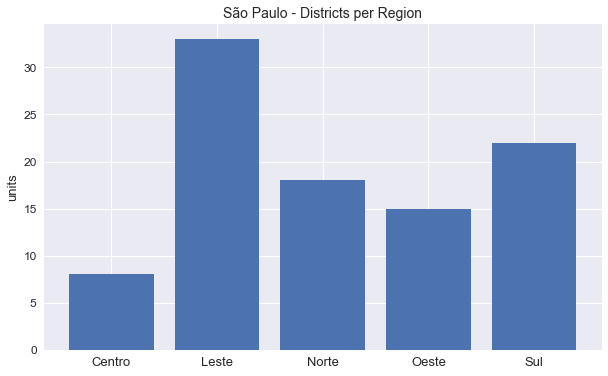

In [58]:
# group dataframe by region counting the group observations
vdf = df_districts.groupby('region').count().reset_index()

# define plot style
plt.style.use('seaborn')

# set font size for axis ticks
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=12)

# create figure object
fig, ax = plt.subplots(figsize=(10,6))

# add bar plot to the figure
ax.bar(vdf['region'], vdf['district'])

# add plot title and ylable
ax.set_title('São Paulo - Districts per Region', {'fontsize':14})
ax.set_ylabel('units', {'fontsize':13})

# show the figure
plt.show()

Check __Districts Dataframe__ statistics using _pandas.DataFrame.describe_ method.

In [59]:
df_districts.describe(include='all')

,region,borough,district,area_sqkm,mean_price_sqm
count,96,96,96,96.000000,96.000000
unique,5,32,96,NaN,NaN
top,Leste,Sé,Itaquera,NaN,NaN
freq,33,8,1,NaN,NaN
mean,NaN,NaN,NaN,15.912396,25.785521
std,NaN,NaN,NaN,26.968078,3.597908
min,NaN,NaN,NaN,2.190000,17.700000
25%,NaN,NaN,NaN,7.395000,23.050000
50%,NaN,NaN,NaN,9.780000,25.150000
75%,NaN,NaN,NaN,13.560000,28.467500


Interesting to notice the variation of rental prices across the city, what is expected for metropolis like São Paulo. The Minimum mean price __BRL 17.70/m<sup>2</sup>__ and the maximum __BRL 33.50/m<sup>2</sup>__ almost double. Mean at __25.78__ is balanced with the median at __25.15__. The range between __Q1 = 23.05__ and __Q3 = 28.47__ is not wide, but the relocator budget at __BRL 25.00/m<sup>2</sup>__ should not be an issue.

There is also huge variation in districts land area, ranging from __2.19 km<sup>2</sup>__ to __208.19 km<sup>2</sup>__, what should be considered when looking for venues with __API Fousquare__, as the radius cannot be the same for all of the districts, to minimize overlaping and skiping areas.

Check the mean prices frequencies with a histograms to have an idea on how is the Relocator Rental Budget positioned, _Matplotlib_ will be used.

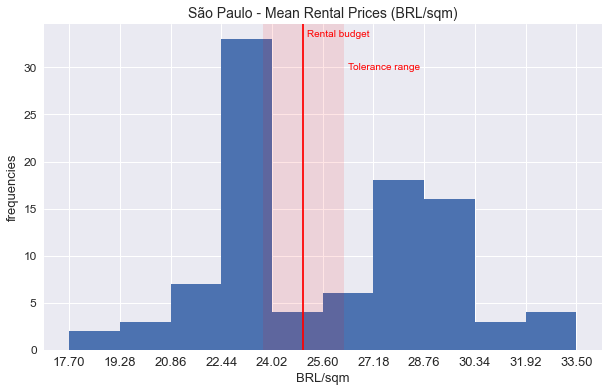

In [60]:
# caculate bins edges
cnt, bins = np.histogram(df_districts['mean_price_sqm'])

# create figure object
fig, ax = plt.subplots(figsize=(10,6))

# add histogram to the figure
ax.hist(df_districts['mean_price_sqm'], bins=bins)

# define xticks values to match bins edges
ax.set_xticks(bins)

# get yticks (values on y-axis)
ylocs, ylabels = plt.yticks()

# add a vertical line for rental budget and annotate a text for it
plt.axvline(x=budget_sqm, ymin=min(ylocs), ymax=max(ylocs), color='r')
ax.annotate('Rental budget', xy=(budget_sqm*1.005, max(ylocs)*0.95), xycoords='data', color='r')

# add a rectangle for the tolerance range and annotate a text for it
rect = plt.Rectangle((budget_sqm_min, min(ylocs)), (budget_sqm_max-budget_sqm_min), (max(ylocs)-min(ylocs)), facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.annotate('Tolerance range', xy=(budget_sqm_max*1.005, max(ylocs)*0.85), xycoords='data', color='r')

# add plot title and ylable
ax.set_title('São Paulo - Mean Rental Prices (BRL/sqm)', {'fontsize':14})
ax.set_xlabel('BRL/sqm', {'fontsize':13})
ax.set_ylabel('frequencies', {'fontsize':13})

# show the figure
plt.show()

Check the mean prices frequencies, but split between district, with the same bin setup for better comparison.

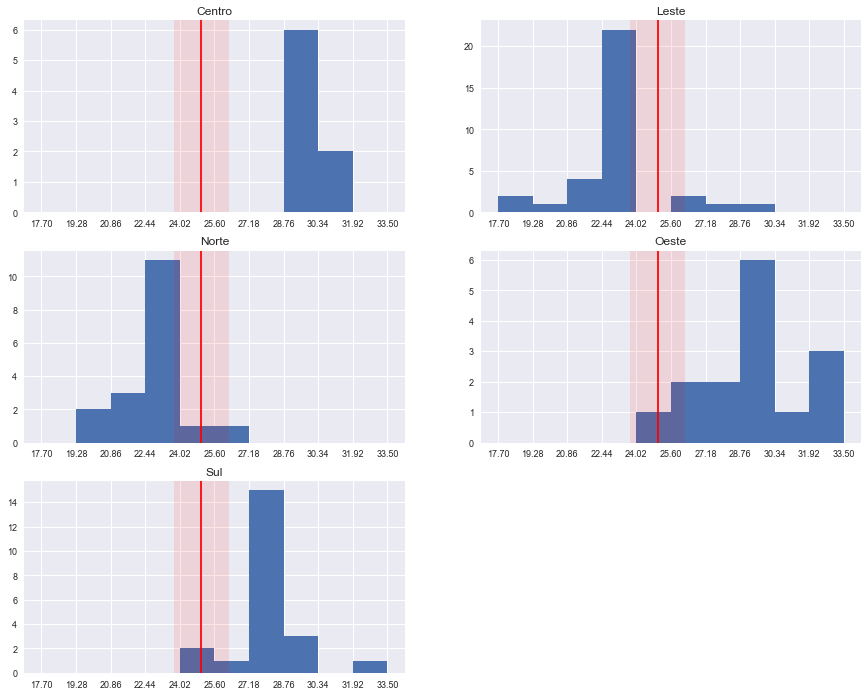

In [61]:
# create a list of unique regions
reglist = list(df_districts['region'].unique())

# set the font size for axis ticks (values)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

# create figure object
fig = plt.figure(figsize=(15,12))

# run a loop through the regions list
for i, r in enumerate(reglist):
    # add plot for current region
    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(df_districts[df_districts['region']==r]['mean_price_sqm'], bins=bins)

    # define the xticks to match the bins edges of current region
    ax.set_xticks(bins)
    
    # get yticks (values on y-axis)
    ylocs, ylabels = plt.yticks()
    
    # add a vertical line for rental budget
    plt.axvline(x=budget_sqm, ymin=min(ylocs), ymax=max(ylocs), color='r')
    
    # add a rectangle for the tolerance range
    rect = plt.Rectangle((budget_sqm_min, min(ylocs)), (budget_sqm_max-budget_sqm_min), (max(ylocs)-min(ylocs)), facecolor='r', alpha=0.1)
    ax.add_patch(rect)

    # add plot title for the current region
    ax.set_title(r, {'fontsize':12})

# show the figure
plt.show()

It is visible here that each region has a different rental prices range, with an of overlaping in middle prices, exception is _Centro_  region (downtown), which has a higher rental prices starting from __BRL28.76/m<sup>2</sup>__. The high frequency between __22.44 and 24.02__, found in previous histogram, is concentrated in regions _Leste_ and _Norte_.

Looking only at the rental prices, except from _Centro_, all the other regions are candidates for having the Relocator.

---

### Step 5 - Create a map to show the Districts of _Target Location_

Import addional libraries.
1. __Folium__: create maps
1. __Geopy__: get geographical data

In [62]:
import folium
from geopy.geocoders import Nominatim

To point the districts on the map, their coordinates are required. Get districts coodinates will be done with _geopy.geocoders.Nominatim_, for better accuracy, the search will be done with __district__ and __borough__ followed by __"São Paulo, BR__", if it is not found, __borough__ will be removed for a second search.

In [63]:
# define geolocator user agent
geolc = Nominatim(user_agent="sp_search")

# get São Paulo coordenates to start the map
loct = geolc.geocode('São Paulo, BR')
latsp = round(loct.latitude, 4)
lngsp = round(loct.longitude, 4)

# create a temporary list
coord = []

# run a loop through the dataframe
for r, b, d, a in zip(df_districts['region'], df_districts['borough'], df_districts['district'], df_districts['area_sqkm']):
    # set a variable to search location
    vloc = d + ', ' + b + ', São Paulo, BR'

    # send the geocode search
    loct = geolc.geocode(vloc)
    
    # if it fails, try without borough
    if loct == None:
        vloc = d + ', São Paulo, BR'
        loct = geolc.geocode(vloc)

    # append results to the temporary list
    if loct != None:
        # append results into the list
        coord.append([r, d, a, round(loct.latitude,4), round(loct.longitude,4)])

# check results and print status
if len(coord) > 0:
    print('{} coordinates acquired.'.format(len(coord)))
else:
    print('Fail to acquire coordinates.')

96 coordinates acquired.


Store coordinates into __Coordinates Dataframe__ using _pandas.DataFrame_ method.

In [64]:
# store coordinates into dataframe
df_coord = pd.DataFrame(coord, columns=['region', 'district', 'area_sqkm', 'latitude', 'longitude'])

# print results
df_coord

,region,district,area_sqkm,latitude,longitude
0,Centro,Bela Vista,2.72,-23.5622,-46.6478
1,Centro,Bom Retiro,4.21,-23.5271,-46.6368
2,Centro,Cambuci,3.92,-23.5661,-46.6137
3,Centro,Consolação,3.82,-23.5578,-46.6605
4,Centro,Liberdade,3.65,-23.5552,-46.6356
...,...,...,...,...,...
91,Sul,Campo Grande,12.95,-23.6578,-46.6986
92,Sul,Santo Amaro,16.04,-23.6562,-46.7191
93,Sul,Moema,9.08,-23.5827,-46.6490
94,Sul,Saúde,9.31,-23.5973,-46.6359


Define a __regions color table__ for better visualization on the map. Color definition will be done with _Matplotlib_ and then they will be attached to the regions in __Coordinates Dataframe__ using _pandas.merge_ method.

In [65]:
# create a list of unique boroughs
reglist = df_coord['region'].unique()

# create a color list by borough [RGBA format]
trgb = plt.cm.tab10(np.linspace(0, 1, len(reglist)))

# convert the color from RGBA to HEX
thex = []
for i in range(len(trgb)):
    thex.append(mcolors.rgb2hex(trgb[i][:3]))

# create a temporary list to assign colors to regions
tmplist = list()
for b, c in zip(reglist, thex):
    tmplist.append([b,c])

# create a dataframe from the temporary list
colortable = pd.DataFrame(columns=['region','region_color'], data=tmplist)

# merge coord and color table data frames
df_coord = pd.merge(df_coord, colortable, how='left', on='region')

# print results
df_coord.head()

,region,district,area_sqkm,latitude,longitude,region_color
0,Centro,Bela Vista,2.72,-23.5622,-46.6478,#1f77b4
1,Centro,Bom Retiro,4.21,-23.5271,-46.6368,#1f77b4
2,Centro,Cambuci,3.92,-23.5661,-46.6137,#1f77b4
3,Centro,Consolação,3.82,-23.5578,-46.6605,#1f77b4
4,Centro,Liberdade,3.65,-23.5552,-46.6356,#1f77b4


Create a map of São Paulo pointing its Districts, it will be done _Folium_.

### Important notice:
Unfortunately the Folium maps are not displayed in GitHub, they are interactive objects not supported, as an option to see the maps the [Jupyter nbviewer](https://nbviewer.org/) can be used. Once it is opened just need to paste the URL of the GitHub document.

---

In [66]:
# create the map
sp_map = folium.Map(location=[latsp, lngsp], width='70%', height='70%',
                    min_zoom=9, max_zoom=12, zoom_start=10, control_scale=True)

# run a loop through the dataframe creating the points (circle marks)
for lat, lng, reg, dst, clr in zip(df_coord['latitude'], df_coord['longitude'], df_coord['region'],
                                   df_coord['district'], df_coord['region_color']):
    # create marker label
    label = '{} ({})'.format(dst, reg)
    label = folium.Popup(label, parse_html=True)
    
    # create the circle mark
    folium.CircleMarker([lat, lng],
                        popup = label, 
                        radius = 5,
                        color = clr,
                        fill = True,
                        fill_color = clr,
                        fill_opacity = 0.3,
                        parse_html = False,
                        no_touch=True).add_to(sp_map)

# show the map
sp_map

---

### Step 6 - Get Districts Venues Information

Import addional libraries.
1. __Credentials__: API credentials, local user defined package
1. __Json__: manipulate files in _json_ format
1. __Math__: mathematical formulas

In [67]:
import credentials
import json
import math

Search for districts venues. The __API Foursquare__ will be used to search venues based on the districts coordinates, for each district a request will be sent to the API using _requests.get_ method and responses will be interpreted with _json_ method.

Get __API Foursquare credentials__. The connection to __API Foursquare__ requires private user credentials, they have previouly been requested and stored into the local user defined package _Credentials_.

In [68]:
# get the credentials, token will not be used
client_id, client_secret, access_token = credentials.get_foursquare()

Will also be defined the __API version__ (required), __limit of venues__ to be returned and the __search radius__ around the location.

API version and limit of venues will be fixed, radius will be set according to each district area (km<sup>2</sup>) by the formula below, limited to 2000 meter radius.

$$\frac{\sqrt{area {km}^2}{2}100 = \sqrt{area {km}^2} * 50$$

The search will be limited to the Relocator __Priority List__, the _dictionary indexes_ will be converted into a single string, having each of the _indexes_ separated by comma and without blank spaces to be used as input for the API request.


In [69]:
# define API version and limit
api_version = '20180605'
limit = 50

# convert priority list to a single string
priocateg = str(list(prio_list.keys())).strip('[]').replace('\'','').replace(' ','')

# create an empty list to store venues information
venueslist = []

# run a loop through the dataframe
for ndistrict, nlat, nlng, narea in zip(df_coord['district'], df_coord['latitude'], df_coord['longitude'], df_coord['area_sqkm']):
    # define radius for current district
    radius = int(math.sqrt(a)*500) if round(math.sqrt(a)*500,0)<=2000 else 2000
    
    # create the API Foursquare request URL
    url='https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.\
    format(client_id, client_secret, api_version, nlat, nlng, radius, limit, priocateg)
    
    # make the GET request and store in JSON format
    vresponse = requests.get(url).json()['response']['venues']

    # add to temporary list only relevant information for each venue
    for v in vresponse:
        venueslist.append([ndistrict,
                            nlat,
                            nlng,
                            v['name'],
                            v['location']['lat'],
                            v['location']['lng'],
                            v['categories'][0]['name']])

# print the quantity of venues returned
print('{} venues returned.'.format(len(venueslist)))

3679 venues returned.


Create the __Venues Dataframe__ to store the response form __API Foursquare__, using _pandas.DataFrame_.

In [70]:
# create Venues Dataframe
df_venues = pd.DataFrame(data=venueslist, columns=['district',
                                                   'district_latitude',
                                                   'district_longitude',
                                                   'venue_name',
                                                   'venue_latitude',
                                                   'venue_longitude',
                                                   'venue_category'])

# print results
df_venues

,district,district_latitude,district_longitude,venue_name,venue_latitude,venue_longitude,venue_category
0,Bela Vista,-23.5622,-46.6478,Drograsil,-23.562127,-46.652414,Pharmacy
1,Bela Vista,-23.5622,-46.6478,Estação Brigadeiro (Metrô),-23.568441,-46.647965,Metro Station
2,Bela Vista,-23.5622,-46.6478,Estação Vergueiro (Metrô),-23.568846,-46.639957,Metro Station
3,Bela Vista,-23.5622,-46.6478,Estação São Joaquim (Metrô),-23.561901,-46.638587,Metro Station
4,Bela Vista,-23.5622,-46.6478,Estação Liberdade (Metrô),-23.555199,-46.635612,Metro Station
...,...,...,...,...,...,...,...
3674,Vila Mariana,-23.5892,-46.6347,Drogaria São Paulo,-23.598622,-46.639823,Pharmacy
3675,Vila Mariana,-23.5892,-46.6347,Praça Rosa Alves da Silva,-23.579476,-46.632390,Plaza
3676,Vila Mariana,-23.5892,-46.6347,Droga Raia,-23.592650,-46.621110,Pharmacy
3677,Vila Mariana,-23.5892,-46.6347,Praça Kant,-23.592505,-46.623091,Park


Check how many unique __categories__ have been returned, using _pandas.DataFrame.unique_ method.

In [71]:
# print quantity of unique categories
print('{} unique categories returned.'.format(len(df_venues['venue_category'].unique())))

39 unique categories returned.


When specifying categories to __API Foursquare__, all the sub-categories are returned in response. For the 5 categories in __Priority List__, 39 venues categories have returned.

Remove venues of not required categories, using _pandas.DataFrame.isin_ method, then create the __Summary Dataframe__ with the venues quantity for each district, using _pandas.pivot_table_ method.

In [72]:
# remove venues of not required categories
df_venues = df_venues[df_venues['venue_category'].isin(list(prio_list.values()))]

# create Summary Dataframe
df_summary = pd.pivot_table(df_venues, values='venue_name', index='district', columns='venue_category', aggfunc='count')

# print results
df_summary

venue_category,Elementary School,Metro Station,Park,Pharmacy,Supermarket
district,,,,,
Alto de Pinheiros,2.0,1.0,12.0,24.0,5.0
Anhanguera,1.0,NaN,2.0,NaN,NaN
Aricanduva,9.0,NaN,1.0,18.0,4.0
Artur Alvim,6.0,4.0,NaN,33.0,5.0
Barra Funda,3.0,3.0,2.0,21.0,16.0
...,...,...,...,...,...
Vila Matilde,6.0,2.0,3.0,25.0,11.0
Vila Medeiros,9.0,NaN,1.0,33.0,3.0
Vila Prudente,5.0,3.0,7.0,23.0,8.0


From the 96 districts, 3 of them have none of the __Priority List__ categories, merge the __Districts Dataframe__ with __Summary Dataframe__ to have all the 96 districts available for ranking, _pandas.merge_ will be used.

In [73]:
# merge Districts and Summary dataframes
df_summary = pd.merge(left=df_districts['district'], right=df_summary, how='left', on='district')

# print results
df_summary

,district,Elementary School,Metro Station,Park,Pharmacy,Supermarket
0,Bela Vista,NaN,5.0,NaN,16.0,26.0
1,Bom Retiro,2.0,6.0,2.0,29.0,6.0
2,Cambuci,2.0,1.0,6.0,30.0,7.0
3,Consolação,NaN,5.0,1.0,20.0,20.0
4,Liberdade,NaN,8.0,1.0,16.0,21.0
...,...,...,...,...,...,...
91,Campo Grande,3.0,4.0,5.0,27.0,7.0
92,Santo Amaro,4.0,6.0,4.0,32.0,2.0
93,Moema,NaN,4.0,3.0,28.0,11.0
94,Saúde,1.0,7.0,2.0,30.0,8.0


Categories which have not been returned have been set as _NaN_ when creating the _Pivot Table_ dataframe. Replace _NaN_ entries by 0 (zero) using _pandas.DataFrame.fillna_ method.

In [74]:
# replace NaN entries by 0
df_summary.fillna(value=0, inplace=True)

# print results
df_summary

,district,Elementary School,Metro Station,Park,Pharmacy,Supermarket
0,Bela Vista,0.0,5.0,0.0,16.0,26.0
1,Bom Retiro,2.0,6.0,2.0,29.0,6.0
2,Cambuci,2.0,1.0,6.0,30.0,7.0
3,Consolação,0.0,5.0,1.0,20.0,20.0
4,Liberdade,0.0,8.0,1.0,16.0,21.0
...,...,...,...,...,...,...
91,Campo Grande,3.0,4.0,5.0,27.0,7.0
92,Santo Amaro,4.0,6.0,4.0,32.0,2.0
93,Moema,0.0,4.0,3.0,28.0,11.0
94,Saúde,1.0,7.0,2.0,30.0,8.0


---

### Step 7 - Create the _Districts Rank_ according to the _Relocator Profile_